In [27]:
import os

base_path = "/kaggle/input/plantdisease/PlantVillage"
tomato_classes = [d for d in os.listdir(base_path) if d.lower().startswith("tomato")]
print("Tomato classes:", tomato_classes)


Tomato classes: ['Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Tomato__Target_Spot', 'Tomato_Late_blight', 'Tomato__Tomato_mosaic_virus']


In [28]:
import os
import shutil
import random
from tqdm import tqdm

# Paths
src_dir = "/kaggle/input/plantdisease/PlantVillage"
dst_base = "/kaggle/working/TomatoDataset"
train_dir = os.path.join(dst_base, "train")
val_dir = os.path.join(dst_base, "val")

# List only tomato classes
tomato_classes = [d for d in os.listdir(src_dir) if d.lower().startswith("tomato")]

# Make train/val directories
for split_dir in [train_dir, val_dir]:
    os.makedirs(split_dir, exist_ok=True)
    for cls in tomato_classes:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

# Split and copy
for cls in tqdm(tomato_classes):
    cls_path = os.path.join(src_dir, cls)
    images = os.listdir(cls_path)
    random.shuffle(images)

    split_idx = int(0.8 * len(images))
    train_images = images[:split_idx]
    val_images = images[split_idx:]

    for img in train_images:
        src = os.path.join(cls_path, img)
        dst = os.path.join(train_dir, cls, img)
        shutil.copyfile(src, dst)

    for img in val_images:
        src = os.path.join(cls_path, img)
        dst = os.path.join(val_dir, cls, img)
        shutil.copyfile(src, dst)

print("✅ Done! Training and validation datasets are ready in:", dst_base)


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]

✅ Done! Training and validation datasets are ready in: /kaggle/working/TomatoDataset


In [16]:
train_dir = "/kaggle/working/TomatoDataset/train"
val_dir = "/kaggle/working/TomatoDataset/val"


In [18]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf


In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [35]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 15988 images belonging to 10 classes.
Found 9824 images belonging to 10 classes.


In [21]:
y_train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: 0.7504245283018868, 1: 1.605348133198789, 2: 0.8404120443740095, 3: 1.6781645569620254, 4: 0.9064957264957265, 5: 0.9583734939759037, 6: 1.1412482065997132, 7: 0.4966906025600999, 8: 4.323097826086957, 9: 1.0088142041851618}


In [16]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load VGG19 base model without top classifier
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [22]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,158,284 (76.90 MB)

 Trainable params: 20,156,490 (76.89 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 2 (12.00 B)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='best_vgg19_tomato_model.h5',
    save_best_only=True,
    monitor='val_loss'
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
401/401 ━━━━━━━━━━━━━━━━━━━━ 147s 357ms/step - accuracy: 0.1067 - loss: 2.4984 - val_accuracy: 0.2872 - val_loss: 2.1953
Epoch 2/30
401/401 ━━━━━━━━━━━━━━━━━━━━ 142s 353ms/step - accuracy: 0.1620 - loss: 2.2761 - val_accuracy: 0.4119 - val_loss: 2.0672
Epoch 3/30
401/401 ━━━━━━━━━━━━━━━━━━━━ 142s 354ms/step - accuracy: 0.2217 - loss: 2.1890 - val_accuracy: 0.4571 - val_loss: 1.9708
Epoch 4/30
401/401 ━━━━━━━━━━━━━━━━━━━━ 141s 352ms/step - accuracy: 0.2687 - loss: 2.1041 - val_accuracy: 0.5008 - val_loss: 1.8341
Epoch 5/30
401/401 ━━━━━━━━━━━━━━━━━━━━ 141s 351ms/step - accuracy: 0.3262 - loss: 2.0163 - val_accuracy: 0.4634 - val_loss: 1.7572
Epoch 6/30
401/401 ━━━━━━━━━━━━━━━━━━━━ 142s 355ms/step - accuracy: 0.3621 - loss: 1.9206 - val_accuracy: 0.5195 - val_loss: 1.6533
Epoch 7/30
401/401 ━━━━━━━━━━━━━━━━━━━━ 142s 355ms/step - accuracy: 0.3779 - loss: 1.8645 - val_accuracy: 0.5251 - val_loss: 1.5616
Epoch 8/30
401/401 ━━━━━━━━━━━━━━━━━━━━ 142s 353ms/step - accuracy: 0.3820 -

KeyboardInterrupt: 

In [ ]:
##TUNING

In [55]:
from tensorflow.keras.models import load_model

# Replace with actual path
model = load_model('/kaggle/working/Tomato_tuned.h5')


In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/working/TomatoDataset/val',  # e.g., 'data/test'
    target_size=(224, 224),  # should match your training image size
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

import numpy as np

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_labels,digits=4))




Found 9824 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


307/307 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step
                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot     0.9882    0.9937    0.9910      1269
                        Tomato_Early_blight     0.9931    0.9862    0.9896       581
                         Tomato_Late_blight     0.9956    0.9991    0.9974      1137
                           Tomato_Leaf_Mold     1.0000    0.9939    0.9970       661
                  Tomato_Septoria_leaf_spot     0.9980    0.9912    0.9946      1021
Tomato_Spider_mites_Two_spotted_spider_mite     0.9969    0.9788    0.9878       992
                        Tomato__Target_Spot     0.9601    0.9941    0.9768       848
      Tomato__Tomato_YellowLeaf__Curl_Virus     1.0000    0.9935    0.9968      2165
                Tomato__Tomato_mosaic_virus     1.0000    0.9955    0.9977       221
                             Tomato_healthy     0.9925    1.0000    0.9962       929

                    

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


307/307 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step
📉 Log Loss: 0.0237
📈 Cohen’s Kappa: 0.9917
📈 MCC: 0.9918


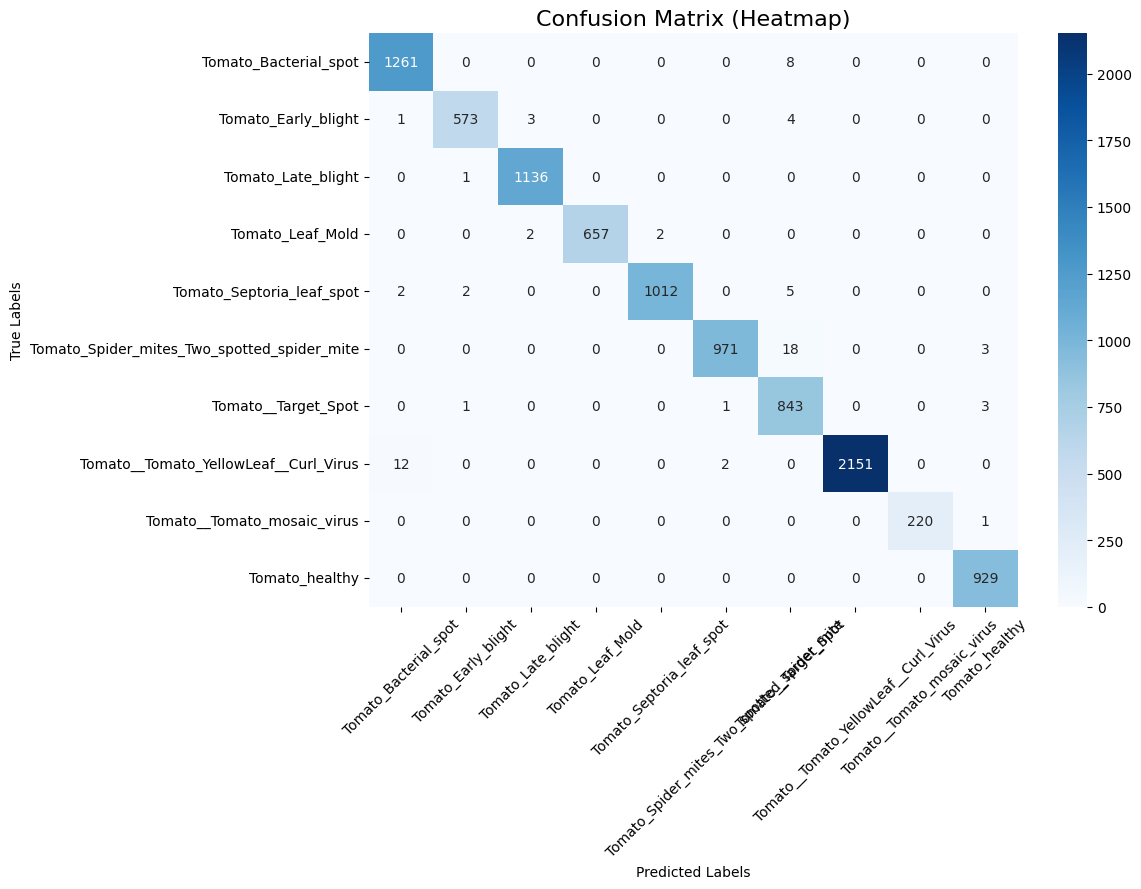

In [36]:
import numpy as np
from sklearn.metrics import (
    log_loss, cohen_kappa_score, matthews_corrcoef, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# --- Predictions ---
val_generator.reset()  # VERY IMPORTANT
y_pred_probs = model.predict(val_generator)
y_true = val_generator.classes
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Metrics ---
logloss = log_loss(y_true, y_pred_probs)
print(f"📉 Log Loss: {logloss:.4f}")

kappa = cohen_kappa_score(y_true, y_pred)
print(f"📈 Cohen’s Kappa: {kappa:.4f}")

mcc = matthews_corrcoef(y_true, y_pred)
print(f"📈 MCC: {mcc:.4f}")

# --- Binarized labels for ROC/AUC ---
n_classes = len(val_generator.class_indices)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# --- Confusion Matrix Heatmap ---
cm = confusion_matrix(y_true, y_pred)
labels = list(val_generator.class_indices.keys())

plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix (Heatmap)', fontsize=16)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



<Figure size 1000x800 with 0 Axes>

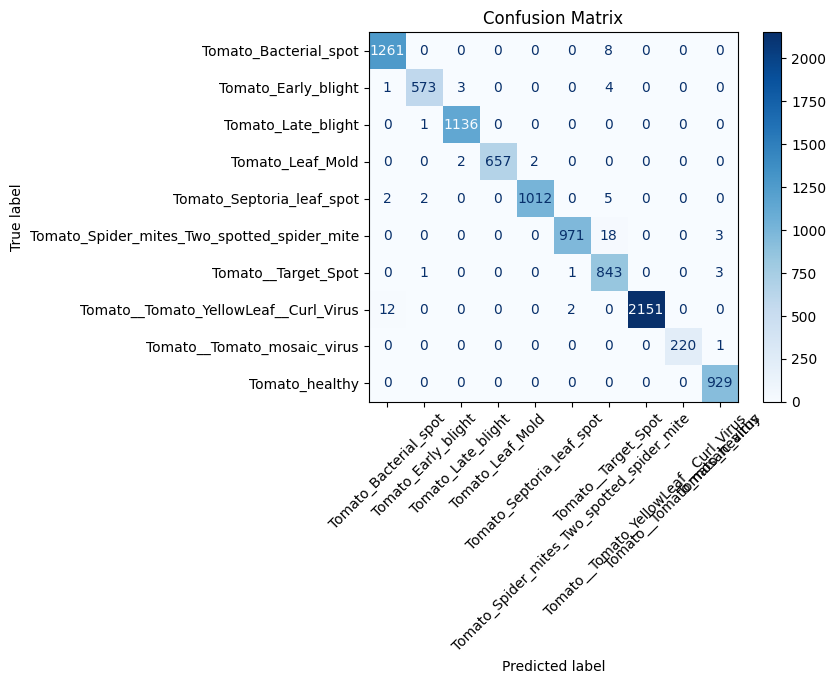

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
#NEW TRAINING

In [171]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#  Training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/TomatoDataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

#  Validation data (no augmentation, just rescale)
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/working/TomatoDataset/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 12804 images belonging to 10 classes.
Found 3207 images belonging to 10 classes.


In [166]:
for layer in model.layers[-60:]:
    layer.trainable = True

from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

# from tensorflow.keras.optimizers import SGD

# model.compile(
#     optimizer=SGD(learning_rate=1e-4, momentum=0.9, nesterov=True),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

In [167]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7)
checkpoint = ModelCheckpoint('retrained_model.h5', save_best_only=True)


In [168]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
401/401 ━━━━━━━━━━━━━━━━━━━━ 174s 407ms/step - accuracy: 0.9961 - loss: 0.0144 - val_accuracy: 0.9900 - val_loss: 0.0376 - learning_rate: 1.0000e-06
Epoch 2/30
401/401 ━━━━━━━━━━━━━━━━━━━━ 156s 389ms/step - accuracy: 0.9935 - loss: 0.0204 - val_accuracy: 0.9829 - val_loss: 0.0567 - learning_rate: 1.0000e-06
Epoch 3/30
401/401 ━━━━━━━━━━━━━━━━━━━━ 153s 382ms/step - accuracy: 0.9943 - loss: 0.0169 - val_accuracy: 0.9838 - val_loss: 0.0520 - learning_rate: 1.0000e-06
Epoch 4/30
401/401 ━━━━━━━━━━━━━━━━━━━━ 154s 382ms/step - accuracy: 0.9942 - loss: 0.0163 - val_accuracy: 0.9807 - val_loss: 0.0760 - learning_rate: 1.0000e-06
Epoch 5/30
401/401 ━━━━━━━━━━━━━━━━━━━━ 150s 374ms/step - accuracy: 0.9961 - loss: 0.0157 - val_accuracy: 0.9841 - val_loss: 0.0585 - learning_rate: 3.0000e-07
Epoch 6/30
401/401 ━━━━━━━━━━━━━━━━━━━━ 151s 377ms/step - accuracy: 0.9954 - loss: 0.0145 - val_accuracy: 0.9847 - val_loss: 0.0578 - learning_rate: 3.0000e-07


In [33]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# === Load class indices from ImageDataGenerator ===
temp_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/kaggle/working/TomatoDataset/val',
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)
class_indices = temp_gen.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}
num_classes = len(class_indices)
print("Class indices:", class_indices)

# === Load images and true labels ===
X = []
y = []

for class_name, label_idx in class_indices.items():
    class_dir = os.path.join('/kaggle/working/TomatoDataset/val', class_name)
    for file in os.listdir(class_dir):
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(class_dir, file)
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img) / 255.0  # normalize
            X.append(img_array)
            y.append(label_idx)

X = np.array(X)
y = np.array(y)

print(f"\n✅ Loaded {X.shape[0]} images across {num_classes} classes.")

# === 10-Fold Accuracy Evaluation ===
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
    X_test, y_test = X[test_idx], y[test_idx]

    y_prob = model.predict(X_test, batch_size=32, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Fold {fold}: Accuracy = {acc:.4f}")

# === 1-Time AUC on full validation set ===
print("\n📈 Calculating full-set AUC on entire validation set...")

y_prob_full = model.predict(X, batch_size=32, verbose=0)
y_bin = label_binarize(y, classes=list(range(num_classes)))

try:
    auc_full = roc_auc_score(y_bin, y_prob_full, multi_class='ovr')
    print(f"📊 ✅ AUC (full set): {auc_full:.4f}")
except ValueError:
    print("⚠️ AUC could not be computed — possibly due to missing classes in one-hot labels.")

# === Final Accuracy Result ===
mean_acc = np.mean(accuracies)
print(f"\n✅ Final 10-Fold Mean Accuracy: {mean_acc * 100:.4f}%")


Found 9824 images belonging to 10 classes.
Class indices: {'Tomato_Bacterial_spot': 0, 'Tomato_Early_blight': 1, 'Tomato_Late_blight': 2, 'Tomato_Leaf_Mold': 3, 'Tomato_Septoria_leaf_spot': 4, 'Tomato_Spider_mites_Two_spotted_spider_mite': 5, 'Tomato__Target_Spot': 6, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 7, 'Tomato__Tomato_mosaic_virus': 8, 'Tomato_healthy': 9}

✅ Loaded 9824 images across 10 classes.
Fold 1: Accuracy = 0.9939
Fold 2: Accuracy = 0.9949
Fold 3: Accuracy = 0.9888
Fold 4: Accuracy = 0.9980
Fold 5: Accuracy = 0.9929
Fold 6: Accuracy = 0.9949
Fold 7: Accuracy = 0.9898
Fold 8: Accuracy = 0.9908
Fold 9: Accuracy = 0.9878
Fold 10: Accuracy = 0.9959

📈 Calculating full-set AUC on entire validation set...
📊 ✅ AUC (full set): 1.0000

✅ Final 10-Fold Mean Accuracy: 99.2772%


In [40]:
import numpy as np, matplotlib.pyplot as plt, os, tempfile
from IPython.display import display
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import ipywidgets as widgets

# ---------- CONFIG ----------
IMG_SIZE = (224, 224)      # must match training
TOP_K    = 3               # show top‑k predictions
class_map = {v: k for k, v in val_generator.class_indices.items()}
# ----------------------------

def predict_and_show(img_path):
    """Loads `img_path`, displays it, and prints top‑k predictions."""
    # Display image
    img = load_img(img_path, target_size=IMG_SIZE)
    display(img)
    
    # Preprocess
    x = img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    
    # Predict
    probs = model.predict(x, verbose=0)[0]
    top_idx = probs.argsort()[-TOP_K:][::-1]
    
    # Results
    print(f"\nTop {TOP_K} predictions:")
    for rank, idx in enumerate(top_idx, 1):
        print(f"{rank}. {class_map[idx]:45s}  {probs[idx]*100:6.2f}%")
        
    # Optional uncertainty flag
    if probs[top_idx[0]] < 0.55:
        print("\n⚠️  Low confidence — consider this ‘unknown / uncertain’.")

# ---------- Widget ----------
uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)

def _on_upload_change(change):
    if uploader.value:
        # Save upload to a temporary file
        name, info = next(iter(uploader.value.items()))
        tmp_path = os.path.join(tempfile.gettempdir(), name)
        with open(tmp_path, 'wb') as f:
            f.write(info['content'])
        predict_and_show(tmp_path)

uploader.observe(_on_upload_change, names='value')


FileUpload(value=(), accept='image/*', description='Upload')

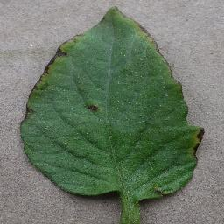


Top 3 predictions:
1. Tomato_Bacterial_spot                          100.00%
2. Tomato__Target_Spot                              0.00%
3. Tomato_Early_blight                              0.00%


In [50]:

import os, tempfile

if uploader.value:
    uploaded_file = uploader.value[0]  # grab the first (and only) file
    name = uploaded_file['name']
    content = uploaded_file['content']

    # Save to a temporary location
    tmp_path = os.path.join(tempfile.gettempdir(), name)
    with open(tmp_path, 'wb') as f:
        f.write(content)

    # Run the prediction
    predict_and_show(tmp_path)
else:
    print("⚠️ No file uploaded yet.")

